In [15]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import *

In [16]:
MISSING = -9999

In [17]:
df = pd.read_csv("../data/processed/data_encoded_by_cluster.csv")

In [18]:
df.shape

(39325, 1567)

In [20]:
df_train = df[df["test"] == 0].drop(columns=["test"]).set_index("id")
df_test = df[df["test"] == 1].drop(columns=["test"]).set_index("id")

In [30]:
params = {
    'subsample': 1.0,
    'scale_pos_weight': 1.0,
    'max_depth': 2,
    'colsample_bytree': 0.5,
    'colsample_bynode': 1.0,
    'colsample_bylevel': 0.5
}

In [39]:
models = []
y_pred_test_all = []
y_prob_test_all = []
y_true_test_all = []
for i in range(3):
    df_train_sub = df_train[df_train["cluster"] == i].drop(columns="cluster")
    
    X = df_train_sub.drop(columns=["satisfied"])
    y = df_train_sub["satisfied"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1001)

    final_model = xgb.XGBClassifier(
                                    learning_rate=0.1,
                                    objective='binary:logistic',
                                    silent=True, 
                                    missing=MISSING,
                                    nthread=8,
                                    **params
                                    )
    final_model.fit(X_train, y_train)
    models.append(final_model)
    
    y_pred_train = final_model.predict(X_train)
    y_prob_train = final_model.predict_proba(X_train)[:,1]
    
    y_pred_test = final_model.predict(X_test)
    y_prob_test = final_model.predict_proba(X_test)[:,1]
    
    y_pred_test_all += list(y_pred_test)
    y_prob_test_all += list(y_prob_test)
    y_true_test_all += list(y_test)

    
    print("Cluster {}".format(i))
    print("Train AUC {}".format(roc_auc_score(y_train, y_prob_train)))
    print("Test AUC {}".format(roc_auc_score(y_test, y_prob_test)))

Cluster 0
Train AUC 0.9130239035239053
Test AUC 0.890936826178196
Cluster 1
Train AUC 0.8948241280051308
Test AUC 0.8840726952255309
Cluster 2
Train AUC 0.8831543437375684
Test AUC 0.8619501923676822


In [44]:
df_test['cluster']

id
14061    2
16467    2
25725    2
9100     2
32597    2
        ..
31430    1
3876     1
20710    1
26015    1
12970    1
Name: cluster, Length: 9245, dtype: int64

In [41]:
roc_auc_score(y_true_test_all, y_prob_test_all)

0.8898069154857007

In [55]:
y_prob_final_all = []
for i in range(3):
    df_test_sub = df_test[df_test['cluster'] == i].drop(columns='cluster')
    X_final = df_test_sub.drop(columns=["satisfied"])
    y_pred_final = models[i].predict(X_final)
    y_prob_final = models[i].predict_proba(X_final)[:,1]
    print(pd.Series(y_prob_final, index=X_final.index))
    y_prob_final_all.append(pd.Series(y_prob_final, index=X_final.index))

id
15244    0.353246
15201    0.841937
35019    0.927993
35478    0.478105
21430    0.809919
           ...   
33230    0.912860
813      0.176030
8555     0.817406
27356    0.834357
30586    0.448351
Length: 3685, dtype: float32
id
36533    0.067620
6076     0.503846
21346    0.604539
18531    0.948192
15028    0.262110
           ...   
31430    0.811032
3876     0.546006
20710    0.628674
26015    0.780939
12970    0.069664
Length: 2439, dtype: float32
id
14061    0.145684
16467    0.121243
25725    0.873401
9100     0.799440
32597    0.663577
           ...   
21983    0.131850
4850     0.842680
32103    0.307679
20723    0.381324
34038    0.829747
Length: 3121, dtype: float32


In [64]:
y_result = pd.concat(y_prob_final_all)

In [76]:
df_result = pd.DataFrame(y_result, columns=["Predicted"])

In [79]:
df_result = df_result.loc[df_test.index]

In [80]:
df_result["Id"] = df_result.index

In [81]:
df_result = df_result.reset_index(drop=True)

In [82]:
df_result[["Id", "Predicted"]]

,Id,Predicted
0,14061,0.145684
1,16467,0.121243
2,25725,0.873401
3,9100,0.799440
4,32597,0.663577
...,...,...
9240,31430,0.811032
9241,3876,0.546006
9242,20710,0.628674
9243,26015,0.780939


In [83]:
df_result[["Id", "Predicted"]].to_csv("../data/result/result_03_05_submission1.csv", index=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1.0, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=-9999, n_estimators=100, n_jobs=1,
              nthread=8, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, seed=None,
              silent=True, subsample=1.0, verbosity=1)

(0.8897425457155363, 0.9321853513971671)

No handles with labels found to put in legend.


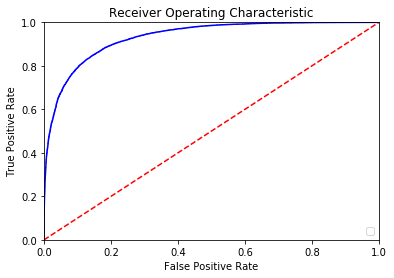

In [18]:
fpr, tpr, threshold = roc_curve(y_train, y_prob_train)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

No handles with labels found to put in legend.


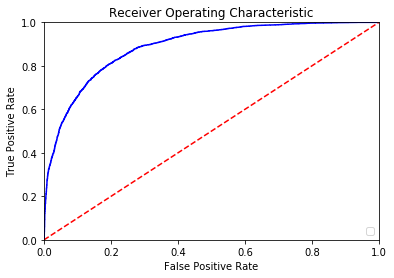

In [19]:
fpr, tpr, threshold = roc_curve(y_test, y_prob_test)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [20]:
(0.8901941061759845, 0.9386534084249205)  #5

(0.8901941061759845, 0.9386534084249205)

In [21]:
(0.8901553362068626, 0.9203028581243273) #4

(0.8901553362068626, 0.9203028581243273)

In [22]:
(0.8896688507329076, 0.9068574909384938) #3

(0.8896688507329076, 0.9068574909384938)

In [23]:
(0.8879588067229542, 0.8971857360901431) #2

(0.8879588067229542, 0.8971857360901431)

In [25]:
df_result = pd.DataFrame(y_prob_final, columns=["Predicted"])

In [26]:
df_result["Id"] = df_test.index

In [27]:
df_result[["Id", "Predicted"]]

,Id,Predicted
0,14061,0.075332
1,16467,0.075800
2,25725,0.945980
3,9100,0.817363
4,32597,0.618506
...,...,...
9240,31430,0.902512
9241,3876,0.541742
9242,20710,0.704785
9243,26015,0.785535


In [29]:
df_result[["Id", "Predicted"]].to_csv("../data/result/result_03_04_submission2.csv", index=False)

In [341]:
y_prob_test

array([0.44119564, 0.28837988, 0.08958686, ..., 0.25904748, 0.06208896,
       0.09483389], dtype=float32)

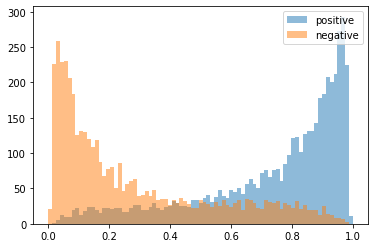

In [347]:
pos = y_prob_test[y_test.astype(bool).values]
neg = y_prob_test[~(y_test.astype(bool).values)]

bins = np.linspace(0, 1, 80)

plt.hist(pos, bins, alpha=0.5, label='positive')
plt.hist(neg, bins, alpha=0.5, label='negative')
plt.legend(loc='upper right')
plt.show()

In [348]:
df_original = pd.read_csv("../data/interim/train.csv")

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,4,6,10,12,18,24,35,56,57,65,85,86,87,88,89,98,99,100,105,124,125,126,127,128,130,131,133,166,171,172,192,193,194,195,204,205,206,207,228,229,230,240,256,257,258,259,260,261,262) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [374]:
df_ori = df_original.set_index("id").loc[X_train.index]

In [375]:
df_ori["pred"] = y_pred_train
df_ori["prob"] = y_prob_train

In [376]:
df_ori["correct"] = (df_ori["satisfied"] == df_ori["pred"]).astype(int)

In [377]:
df_ori

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v266,v267,v268,v269,v270,cntry,satisfied,pred,prob,correct
id,,,,,,,,,,,,,,,,,,,,,
16436,7,2,44,12040,.a,1,2,2,2,1,...,.a,.a,.a,NaN,NaN,NO,1,1.0,0.865028,1
5416,8,1,49,12020,.a,1,1,2,2,1,...,.a,.a,.a,.a,.a,FI,1,1.0,0.984691,1
39101,1,2,72,13060,.a,2,2,2,2,1,...,.a,.a,.a,.a,.a,PT,0,0.0,0.035139,1
28286,5,2,71,11030,.a,2,2,2,2,1,...,.a,.a,.a,.a,NaN,GB,0,0.0,0.110533,1
3419,5,2,73,11080,.a,2,2,2,2,1,...,.a,.a,.a,.a,.a,IE,0,0.0,0.103392,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,1,2,71,11010,11010,2,2,2,2,1,...,.a,.a,.a,.a,NaN,AT,0,0.0,0.069247,1
16426,2,2,57,15040,.a,2,2,2,2,1,...,.a,.a,.a,.a,.a,HU,0,0.0,0.120433,1
14088,0,2,36,11050,11050,2,1,2,2,1,...,2010,.a,.a,.a,NaN,FR,0,0.0,0.454509,1


In [353]:
temp = df_ori.groupby("cntry").agg({"satisfied": ["mean", "count"], "correct": ["mean"]})
temp

satisfied         correct
           mean count      mean
cntry                          
AT     0.565036   961  0.862643
BE     0.750000     4  1.000000
CH     0.730178   845  0.871006
CZ     0.381435  1185  0.854008
DE     0.607143  1652  0.831114
DK     0.813760   843  0.920522
EE     0.358156  1128  0.836879
ES     0.458969  1048  0.818702
FI     0.724826  1152  0.863715
FR     0.399236  1047  0.812798
GB     0.509646  1244  0.845659
HU     0.240000   950  0.874737
IE     0.453210  1293  0.813612
IL     0.571530  1405  0.839146
LT     0.263993  1197  0.878864
NL     0.633523  1056  0.856061
NO     0.712435   772  0.869171
PL     0.483982   874  0.839817
PT     0.271429   700  0.872857
SE     0.692383  1024  0.865234
SI     0.437870   676  0.823964

In [354]:
hapiness = temp["satisfied"]["mean"]
correctness = temp["correct"]["mean"]
size = temp["satisfied"]["count"]

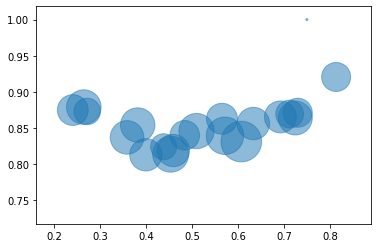

In [355]:
plt.scatter(hapiness, correctness, s=size, alpha=0.5)

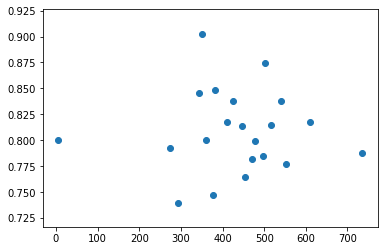

In [267]:
plt.scatter(size, correctness)

In [268]:
temp[temp["correct"]["mean"] < 0.8]

satisfied         correct
           mean count      mean
cntry                          
CZ     0.413655   498  0.785141
DE     0.599185   736  0.788043
EE     0.341004   478  0.799163
ES     0.521186   472  0.781780
FR     0.430769   455  0.764835
IE     0.503623   552  0.777174
PL     0.484043   376  0.747340
PT     0.318493   292  0.739726
SI     0.364964   274  0.791971

In [269]:
bad = temp[(temp["satisfied"]["mean"] > 0.3) & (temp["satisfied"]["mean"] < 0.6)].index

In [272]:
bad_ind = df_ori[df_ori["cntry"].isin(bad)].index

In [273]:
df_train = df[df["test"] == 0].drop(columns=["test"]).set_index("id")

In [276]:
df_train = df_train.loc[bad_ind]

In [277]:
X = df_train.drop(columns=["satisfied"])
y = df_train["satisfied"]

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1001)
# X_train_id, X_test_id, _, _ = train_test_split(X_id, y, test_size=0.30, random_state=1001)

params = {
    'subsample': 1.0,
    'scale_pos_weight': 1.0,
    'max_depth': 2,
    'colsample_bytree': 0.5,
    'colsample_bynode': 1.0,
    'colsample_bylevel': 0.5
}

final_model = xgb.XGBClassifier(
    learning_rate=0.1,
    objective='binary:logistic',
    silent=True, 
    missing=MISSING,
    nthread=8,
    **params
    )


final_model.fit(X_train, y_train)

y_pred_train = final_model.predict(X_train)
y_prob_train = final_model.predict_proba(X_train)[:,1]

y_pred_test = final_model.predict(X_test)
y_prob_test = final_model.predict_proba(X_test)[:,1]

In [285]:
roc_auc_score(y_test, y_prob_test), roc_auc_score(y_train, y_prob_train)

(0.8755794913603105, 0.8904912771560237)

In [287]:
df_ori2 = df_original.set_index("id").loc[X_test.index]

In [288]:
df_ori2["pred"] = y_pred_test
df_ori2["prob"] = y_prob_test

In [289]:
df_ori2["correct"] = (df_ori2["satisfied"] == df_ori2["pred"]).astype(int)

In [290]:
df_ori2

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v266,v267,v268,v269,v270,cntry,satisfied,pred,prob,correct
id,,,,,,,,,,,,,,,,,,,,,
23751,3,2,26,11080,.a,1,2,2,2,1,...,2011,.a,.a,.a,.a,IE,1,1.0,0.861591,1
25617,2,2,47,11010,11010,1,2,2,2,1,...,.a,.a,.a,.a,NaN,AT,1,0.0,0.248110,0
18832,5,2,35,41030,.a,2,2,2,2,2,...,.a,.a,.a,.a,NaN,GB,0,0.0,0.058236,1
12235,9,2,33,15020,.a,2,1,2,2,1,...,.a,.a,NaN,NaN,NaN,CZ,1,1.0,0.863148,1
22091,0,3,54,11080,.a,2,2,2,2,1,...,1988,.a,.a,.a,.a,IE,1,1.0,0.757092,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23529,1,2,58,13070,13990,1,2,1,2,1,...,.a,.a,.a,.a,.a,ES,0,0.0,0.428250,1
2441,0,2,47,43000,.a,1,2,2,2,2,...,.a,.a,.a,.a,.a,PT,0,1.0,0.637797,0
14431,0,3,61,13060,.a,2,2,2,2,1,...,.a,.a,.a,.a,.a,PT,0,0.0,0.210856,1


In [291]:
temp = df_ori2.groupby("cntry").agg({"satisfied": ["mean", "count"], "correct": ["mean"]})
temp

satisfied         correct
           mean count      mean
cntry                          
AT     0.533835   133  0.834586
BE     0.500000     2  1.000000
CZ     0.356061   132  0.810606
DE     0.580357   224  0.776786
EE     0.324841   157  0.821656
ES     0.576923   130  0.815385
FR     0.421053   152  0.789474
GB     0.557047   149  0.825503
IE     0.480769   156  0.794872
PL     0.491379   116  0.732759
PT     0.298851    87  0.770115
SI     0.379310    87  0.793103

In [ ]:
hapiness = temp["satisfied"]["mean"]
correctness = temp["correct"]["mean"]
size = temp["satisfied"]["count"]

In [ ]:
plt.scatter(hapiness, correctness, s=size, alpha=0.5)

In [ ]:
plt.scatter(size, correctness)

In [ ]:
temp[temp["correct"]["mean"] < 0.8]